## Set up env

In [ ]:
%pip install --user torch==1.8.1

In [ ]:
!pip install monai

     |████████████████████████████████| 501kB 8.6MB/s 


In [ ]:
import torch
import numpy as np
import h5py
from tqdm import tqdm
import time

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.metrics import compute_meandice

from scipy.ndimage import distance_transform_edt as distance
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

In [ ]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    RandSpatialCropd,
    CropForegroundd,
    CenterSpatialCropd,
    NormalizeIntensityd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm_gui

## Download data

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvay3q8uv


In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar"


compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
data_dir = os.path.join(root_dir, "Task02_Heart")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

/usr/local/lib/python3.7/dist-packages/monai/apps/utils.py:158: UserWarning: tqdm is not installed, will not show the downloading progress bar.
  warnings.warn("tqdm is not installed, will not show the downloading progress bar.")



downloaded file: /tmp/tmpt0rivzrf/Task02_Heart.tar.
Expected md5 is None, skip md5 check for file /tmp/tmpt0rivzrf/Task02_Heart.tar.


## Set up datasets

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
set_determinism(seed=0)

In [ ]:
image_size = (96, 96, 96)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
     ]
 )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
    ]
)

## Visualize dataset

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


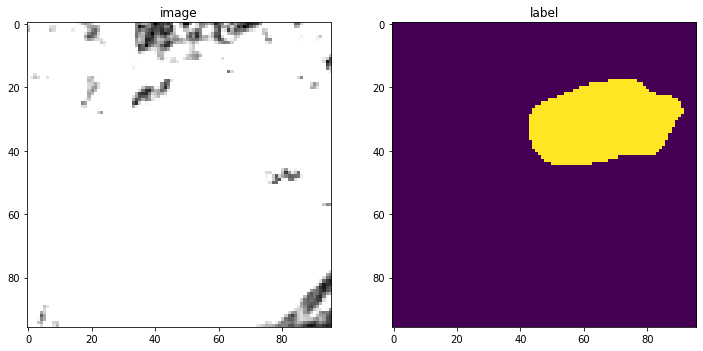

torch.Size([1, 1, 96, 96, 96])


In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()
print(check_data['label'].shape)

## Set up loss functions

In [ ]:
def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss

In [ ]:
def compute_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b].astype(np.bool)
            if posmask.any():
                posdis = distance(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

In [ ]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft[:,1,...] - gt.float()[:,0,...]) ** 2
    s_dtm = seg_dtm[:,1,...] ** 2
    g_dtm = gt_dtm[:,1,...] ** 2
    dtm = s_dtm + g_dtm
    multipled = torch.einsum('bxyz, bxyz->bxyz', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

## Set up dataloader

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
     cache_rate=1.0, num_workers=4)
#train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
  data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:540: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Train

In [ ]:
device = torch.device("cuda:0")
net = monai.networks.nets.BasicUNet().to(device)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [ ]:
base_lr = 0.001
max_iterations = 20000

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)

In [ ]:
iter_num = 0
alpha = 1.0

lr_ = base_lr

In [ ]:
max_epochs = 60
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss = []
metric_values = []
time_list_epoch = []
time_list_batch = []
metric_count = 0
metric_sum = 0.0
new_loss = 0
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

In [ ]:
time.time()

1623274655.5590858

In [ ]:
for epoch_num in range(max_epochs):
    time_list_epoch.append(time.time())
    print("-" * 10)
    print(f"epoch {epoch_num + 1}/{max_epochs}")
    net.train()
    epoch_loss = 0
    step = 0
    for i_batch, sampled_batch in enumerate(train_loader):
        time_list_batch.append(time.time())
        step +=1
        # print('fetch data cost {}'.format(time2-time1))
        # volume_batch.shape=(b,1,x,y,z) label_patch.shape=(b,x,y,z)
        volume_batch, label_batch = sampled_batch['image'].cuda(), sampled_batch['label'].cuda()
        outputs = net(volume_batch)
        outputs, label_batch = outputs.type(torch.Tensor), label_batch.type(torch.Tensor)

        loss_seg = 0
        # for i in range(outputs.size()[2]):
        #     # print(outputs[:, :, i].shape, "\n", label_batch[:, i].shape)
        #     loss_seg += F.cross_entropy(outputs[:, :, i], label_batch[:, i])

        outputs_soft = F.softmax(outputs, dim=1)
        loss_seg_dice = dice_loss(outputs_soft[:, 1, :, :, :], label_batch == 1)
        # compute distance maps and hd loss
        with torch.no_grad():
            # defalut using compute_dtm; however, compute_dtm01 is also worth to try;
            gt_dtm_npy = compute_dtm(label_batch.cpu().numpy(), outputs_soft.shape)
            gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
            seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :, :].cpu().numpy()>0.5, outputs_soft.shape)
            seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)

            

        loss_hd = hd_loss(outputs_soft.cpu(), label_batch.cpu(), seg_dtm.cpu(), gt_dtm.cpu())
        loss = alpha*(loss_seg+loss_seg_dice) + (1 - alpha) * loss_hd
        y_pred = post_pred(outputs)
        y = post_label(label_batch)

        accu = compute_meandice(
                    y_pred=y_pred,
                    y=y,
                    include_background=False,
                )
        acc = accu.sum().item()/len(accu)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss:.4f},"
            f"acc: {acc:.4f}")


        iter_num = iter_num + 1

        ## change lr
        if iter_num % 2500 == 0:
            lr_ = base_lr * 0.1 ** (iter_num // 2500)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        if iter_num % 1000 == 0:
            save_mode_path = os.path.join(snapshot_path, 'iter_' + str(iter_num) + '.pth')
            torch.save(net.state_dict(), save_mode_path)
            logging.info("save model to {}".format(save_mode_path))

        if iter_num > max_iterations:
            break
        time1 = time.time()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch_num + 1} average loss: {epoch_loss:.4f}")
    alpha -= 0.001
    if alpha <= 0.001:
        alpha = 0.001


    if (epoch_num + 1) % val_interval == 0:
        new_loss = 0
        net.eval()
        val_step = 0
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            val_step +=1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].cuda(),
                    val_data["label"].cuda()
                )
                roi_size = (96,96,96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, net)
                val_outputs, val_labels = val_outputs.type(torch.Tensor), val_labels.type(torch.Tensor)
                loss_seg = 0
                outputs_soft = F.softmax(val_outputs, dim=1)
                loss_seg_dice = dice_loss(outputs_soft[:, 1, :, :, :], val_labels == 1)
                # compute distance maps and hd loss
                with torch.no_grad():
                # defalut using compute_dtm; however, compute_dtm01 is also worth to try;
                    gt_dtm_npy = compute_dtm(val_labels.cpu().numpy(), outputs_soft.shape)
                    gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
                    seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :, :].cpu().numpy()>0.5, outputs_soft.shape)
                    seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)

            

                loss_hd = hd_loss(outputs_soft.cpu(), val_labels.cpu(), seg_dtm.cpu(), gt_dtm.cpu())
                val_loss = alpha*(loss_seg+loss_seg_dice) + (1 - alpha) * loss_hd
                new_loss+= val_loss.item()

                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            new_loss /= val_step
            val_epoch_loss.append(new_loss)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch_num + 1
                torch.save(net.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch_num + 1} current mean dice: {metric:.4f} current Val Loss: {val_loss.item():.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/60


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/11, train_loss: 0.8775,acc: 0.0011
2/11, train_loss: 0.8534,acc: 0.0054
3/11, train_loss: 0.8221,acc: 0.0068
4/11, train_loss: 0.8484,acc: 0.0024
5/11, train_loss: 0.8661,acc: 0.0198
6/11, train_loss: 0.8018,acc: 0.0376
7/11, train_loss: 0.7968,acc: 0.1355
8/11, train_loss: 0.7887,acc: 0.1668
9/11, train_loss: 0.8409,acc: 0.1230
10/11, train_loss: 0.7511,acc: 0.2021
11/11, train_loss: 0.7927,acc: 0.1642
epoch 1 average loss: 0.8218
----------
epoch 2/60
1/11, train_loss: 0.8540,acc: 0.1129
2/11, train_loss: 0.8118,acc: 0.1548
3/11, train_loss: 0.8274,acc: 0.1368
4/11, train_loss: 0.7436,acc: 0.2102
5/11, train_loss: 0.7796,acc: 0.1806
6/11, train_loss: 0.7753,acc: 0.1877
7/11, train_loss: 0.8470,acc: 0.1252
8/11, train_loss: 0.7898,acc: 0.1768
9/11, train_loss: 0.8350,acc: 0.1326
10/11, train_loss: 0.7920,acc: 0.1708
11/11, train_loss: 0.7796,acc: 0.1869
epoch 2 average loss: 0.8032
saved new best metric model
current epoch: 2 current mean dice: 0.1377 current Val Loss: 0.8246
best m

KeyboardInterrupt: ignored

In [ ]:
value

tensor([[0.5440]])

In [ ]:
len(val_epoch_loss)

In [ ]:
a = np.array(time_list_epoch)
delta_time_epoch = np.diff(a)

In [ ]:
b = np.array(time_list_batch)
delta_time_step = np.diff(b)

In [ ]:
avg_step_time = np.mean(delta_time_step)
avg_step_time # should be about ~2 seconds per step

In [ ]:
avg_epoch_time = np.mean(delta_time_epoch)
avg_epoch_time # should be about ~20 seconds per epoch

In [ ]:
plt.figure("Train", (40, 20))
plt.subplot(1, 8, 1)
plt.imshow(label_batch[0,0,...,30])
plt.subplot(1, 8, 2)
plt.imshow(label_batch[0,0,...,35])
plt.subplot(1, 8, 3)
plt.imshow(label_batch[0,0,...,40])
plt.subplot(1, 8, 4)
plt.imshow(label_batch[0,0,...,45])
plt.subplot(1, 8, 5)
plt.imshow(label_batch[0,0,...,50])
plt.subplot(1, 8, 6)
plt.imshow(label_batch[0,0,...,55])
plt.subplot(1, 8, 7)
plt.imshow(label_batch[0,0,...,60])
plt.subplot(1, 8, 8)
plt.imshow(label_batch[0,0,...,65])

In [ ]:
plt.imshow(val_outputs.detach().numpy()[0,1,...,40])

In [ ]:
plt.imshow(y_pred[0,1,...,30])

In [ ]:
plt.imshow(label_batch[0,0,...,30])

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
plt.figure("Validation", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Validation Loss")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = val_epoch_loss
plt.xlabel("Epoch")
plt.plot(x, y)
plt.show()

In [ ]:
plt.figure("Time", (30, 6))
plt.title("Time per epoch")
x = [i + 1 for i in range(len(a)-1)]
y = [a[i+1]-a[i] for i in range(len(a)-1)]
plt.xlabel("epoch")
plt.plot(x, y)


In [ ]:
plt.figure("Time", (30, 6))
plt.title("Val Mean Dice")
x = [i + 1 for i in range(len(b)-1)]
y = [b[i+1]-b[i] for i in range(len(b)-1)]
plt.xlabel("batch")
plt.plot(x, y)
plt.show()

In [ ]:
net.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), (roi_size), sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 70])
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 70])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(post_pred(val_outputs).detach().cpu()[0,1,..., 70])
        plt.show()

In [ ]:
import numpy as np

In [ ]:
a = np.ones((5,))

In [ ]:
b = np.diff(a)